# MVP ENGENHARIA DE DADOS

**Nome:** Kaio Santos de Farias

**Matrícula:** 4052025000452

**Dataset:** [Global Superstore](https://www.kaggle.com/datasets/anandaramg/global-superstore?resource=download)


# AVISOS

- O Notebook a seguir consolida todos as informações do fluxo executado no Databricks para a execução do MVP. 
- Parti da inserção da base original retirada do Kaggle no workspace Free Edition do Databricks, construí um pipeline com um conjunto de ações para tratamento dos dados necessários, resultando na construção de um DW em modelo estrela. 
- NO decorrer do notebook, trago todos os descrititvos, análises e racionais utilizados, além dos códigos executados no pipeline, dos registros visuais da exeução do pipeline em Databricks, e das evidências visuais de todos os gráficos construídos. 
- Os mesmos códigos SQL também estarão disponíveis no diertório do github, em formato .sql

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import io
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# PARTE 1 - Contexto e objetivo

## A fonte de dados
Para executar o projeto a seguir, usaremos o dataset Global Superstore, disponível na plataforma Kaggle. 

Segundo as informações apresentadas, o dataset é inspirado no contexto do Walmart, como uma empresa consolidada e fornecedora de diversos tipos de produtos, o que fornece a complexidade e variedade de dados suficientes para alimentar diversos casos de uso e estudo. 

A base de dados resultante inclui uma única tabela, com dados de venda entre os anos de 2011 e 2014. Apesar do aspecto datado dos dados presentes, optamos pela base devido ao seu volume, consistência e variabilidade das informações. 

O dataset escolhido contém uma única tabela, que consolida dados relativos a múltiplos domínios de dados. Em uma implementação real como um Data Warehouse, diversos ajustes em sua estrutura poderiam ajudar na otimização, buscando uma estrutura que permitisse a consulta e análise de maneira simples, rápida e eficiente. 

Portanto, esse será o direcional para a execução do trabalho a seguir. 

## Objetivo do projeto 
## 
O objetivo do projeto é modelar um DW que auxilie o time de vendas e finanças da Superstore a analisar os resultados de vendas da operação e identificar oportunidades de otimização e incremento dos lucros.  
**Perguntas-chave**
- Quais categorias têm a margem de lucro (Lucro / Vendas) mais alta ou mais baixa?
- Quem são os clientes que fizeram o maior volume de compras ou que geraram o maior valor de vendas/lucro?
- Existe oportunidade de melhoria do resultado de lucro no portfolio de produtos?
- Qual é o desempenho de vendas e lucro por mercado?
- Quais as combinações de produto/região que têm gerado a maior margem de lucro? 
- Quais clientes e segmentos representam a maior fatia de receita e lucro? Quais os que devem ser invetigados porque possuem 
- Como o desconto aplicado afeta o lucro e a quantidade de produtos vendidos?
- Qual é o segmento de cliente que contribui com a maior parte das vendas e do lucro?
- Qual é o crescimento anual de vendas e lucro ao longo do tempo? Qual é o desempenho de vendas por número da semana ?
- Quais categorias estão mais propensas a ter pedidos com prioridade alta, e qual é o impacto disso nos custos de envio?
- Qual é o tempo médio de trânsito e como ele varia por modo de envio ou região ?

Para a execução prática das análises, focaremos nas 5 primeiras perguntas. 



# PARTE 2 - Engenharia e construção de DW

## Base original (Masterdata)
A base recebida continha os seguintes campos: 

- category: A categoria de produtos vendidos na superloja.
- city: A cidade onde o pedido foi feito.
- country: O país onde a superloja está localizada.
- customer_id: Um identificador único para cada cliente.
- customer_name: O nome do cliente que fez o pedido.
- discount: O desconto aplicado ao pedido.
- market: O mercado ou região onde a superloja opera.
- 记录数 number_of_records(originalmente em chinês): Uma coluna desconhecida ou não especificada.
- order_date: A data em que o pedido foi feito.
- order_id: Um identificador único para cada pedido.
- order_priority: O nível de prioridade do pedido.
- product_id: Um identificador único para cada produto.
- product_name: O nome do produto.
- profit: O lucro gerado com o pedido.
- quantity: A quantidade de produtos pedidos.
- region: A região onde o pedido foi feito.
- row_id: Um identificador único para cada linha no conjunto de dados.
- sales: O valor total de vendas para o pedido.
- segment: O segmento de cliente (por exemplo, consumidor, corporativo ou escritório doméstico).
- ship_date: A data em que o pedido foi enviado.
- ship_mode: O modo de envio usado para o pedido.
- shipping_cost: O custo de envio para o pedido.
- state: O estado ou região dentro do país.
- sub_category: A subcategoria de produtos dentro da categoria principal.
- year: O ano em que o pedido foi feito.
- market2: Outra coluna relacionada a informações de mercado.
- weeknum: O número da semana em que o pedido foi feito.

## Esquema destino
A base de dados original foi construída em um único arquivo, o que gera alta redundância, replicando múltiplas entidades ao longo das linhas, o que, em uma implementação real, prejudica a performance das plataformas usadas. Para a implementação do DW, precisamos refatorar a base recebida para um modelo dimensional. 
A partir dos campos presentes na base, propomos o seguinte modelo de schema para a base: 
![](path)
![Screenshot 2025-11-30 at 13.45.13.png](./Screenshot 2025-11-30 at 13.45.13.png "Screenshot 2025-11-30 at 13.45.13.png")

##Domínios de dados, descrições e premissas 

- Stores
  - Corresponde às unidades de lojas consideradas. Cada registro nesse domínio/tabela corresponde a uma unidade. 
  - Dado que não possuímos metadados sobre lojas, atuamos com a premissa de que cada país é unicamente unicamente representado no dataset possui uma unidade. 
  - Essa decisão foi tomada de forma a reduzir a complexidade dos dados analisados, removendo um pouco da granularidade de cidades e estados, mas permitindo uma dimensão de loja a ser considerada. 
  - Para identificar cada unidade, criaremos uma chave única que será utilizada para a conexão com as demais tabelas. 
- Products
  - Corresponde a lista de produtos oferecidos nas lojas. Cada produto deve possuir um identificador único, e pertercer a um branch de categoria e subcategoria da árvore de produtos da super store. 
  - Não é permitido que um mesmo produto esteja presente presente em mais de uma subcategoria, nem que uma mesma sub categoria seja listada em 2 categorias diferentes
- Orders
  - Corresponde a lista de pedidos executados, e suas informações adjacentes. 
  - Cada pedido pode ser atrelado a múltiplos itens, mas apenas um único consumidor, e uma única loja
  - Para o contexto do projeto atual, assumimos que todos os items de um mesmo pedido são enviados no mesmo momento. 
- Order Items
  - Corresponde aos itens únicos dos pedidos realizados e suas informações adjacentes. Cada registro nesse domínio possui um identificador único, e pode estar conectado a apenas um pedido e apenas um produto no domínio de produto, e consequentemente, relacionado a apenas um cliente e apenas uma loja. 
  - Sendo assim, é a menor granularidade possível presente no esquema a ser estruturado. 
- Customers
  - Corresponde aos clientes da loja, e suas informações adjacentes. 
  - Cada cliente pode estar relacionado a múltiplos pedidos no domínio de pedidos, e por consequência, podem também ter comprado de múltiplas lojas. 
- Shipping
  - Corresponde aos tipos de envios existentes na operação da super store. 
- Priority
  - Corresponde a tabela que permite a classificação de prioridade dos pedidos realizados. 
- Time
  - Adicionalmente, prevemos uma tabela de tempo a ser utilizada como suporte para análises mais detalhadas. 


## Registros de tratamento e engenharia

Segundo a recomendação do desenvolvimento do MVP, toda a execução do projeto foi realizada utilizando a plataforma Databrick - free edition. 
A base retirada do Kaggle foi manualmente ingerida no workspace como um arquivo .txt, e em seguida, tratada e refatorada em múltiplas tabelas em um modelo de star schema, para construir o output desenhado conforme o schema demonstrado no ERD acima. A construção das tabelas foi feita por meio do desenvolvimento de um pipeline, com múltiplos códigos em SQL, para a geração de cada uma das tabelas. 

Todas as tabelas e colunas resultantes tiveram seus metadados e descritivos cadastrados no catálogo do próprio Databricks, seguindo a recomendação das melhores práticas descritas no curso, contendo descrição dos valores, valores esperados, origem e transformações realizadas. 

Insiro abaixo todas as evidêndias da construção e execução do pipeline, assim como os códigos utilizados. 



### Código SQL utilizado na implementação dos pipelines


Código SQL utilizado na implementação dos pipelines

-- dim_customers
CREATE MATERIALIZED VIEW `workspace`.`default`.`dim_customers`
  (

    customer_id STRING
    COMMENT 'Descrição:  Um identificador único para cada cliente, Origem:  Master data, Formato: integer, Transformação:  Extraído da tabela original, sem ajustes, Valores esperados:  Número inteiro, positivo e maior que zero, Nullable:  Não',
    customer_name STRING
    COMMENT 'Descrição:  O nome do cliente que fez o pedido, Origem:  Master data, Formato: string, Transformação:  Extraído da tabela original, sem ajustes, Número inteiro, positivo e maior que zero String de caracteres com múltiplas palavras, Nullable:  Não',
    segment STRING
    COMMENT 'Descrição:  O segmento de cliente (por exemplo, consumidor, corporativo ou escritório doméstico), Origem:  Master data, Formato: string, Transformação:  Extraído da tabela original, sem ajustes, String de caracteres com múltiplas palavras Pode conter or valores Consumer, Corporate ou Home Office, Nullable:  Não'
  )
  COMMENT 'The table contains information about customers, including their identifiers, names, and segments. This data can be used for customer segmentation analysis, targeted marketing efforts, and understanding customer demographics.' AS
SELECT DISTINCT
  `Customer ID` as customer_id,
  `Customer Name` as customer_name,
  `Segment` as segment
FROM
  workspace.default.superstore_masterdata

-- dim priority
CREATE MATERIALIZED VIEW `workspace`.`default`.`dim_priority`
  (

    priority STRING
    COMMENT 'Descrição:  O nível de prioridade do pedido, Origem:  Master data, Formato: string, Transformação:  Extraído da tabela original, sem ajustes, Pode conter or valores Consumer, Corporate ou Home Office String de caracteres com as opções Critical, HIgh, Low, e Medium , Nullable:  Não',
    priority_level INT
    COMMENT 'Descrição:  Chave que identifica a prioridade do pedido, Origem:  Gerado sistematicamente, Formato: integer, Transformação:  Criado no processo de etl, para permitir conexões , String de caracteres com as opções Critical, HIgh, Low, e Medium  Numério decimal, positivo de 1 a 4, Nullable:  Não'
  ) AS
SELECT DISTINCT
  `Order Priority` AS priority,
  CASE
    WHEN `Order Priority` = 'Critical' THEN 4
    WHEN `Order Priority` = 'High' THEN 3
    WHEN `Order Priority` = 'Medium' THEN 2
    WHEN `Order Priority` = 'Low' THEN 1
    ELSE 0 -- Caso apareça algum valor estranho/nulo, ele recebe 0
  END AS priority_level
FROM
  workspace.default.superstore_masterdata
ORDER BY
  priority_level DESC
-- dim_products
CREATE MATERIALIZED VIEW `workspace`.`default`.`dim_products`
  (

    product_id STRING
    COMMENT 'Descrição:  Um identificador único para cada produto, Origem:  Master data, Formato: string, Transformação:  Extraído da tabela original, sem ajustes, Nome do país, Múltiplas possibilidades String de 16 caracteres, alfanumérico, Nullable:  Não',
    product_name STRING
    COMMENT 'Descrição:  O nome do produto, Origem:  Master data, Formato: string, Transformação:  Extraído da tabela original, sem ajustes, String de 16 caracteres, alfanumérico String de caracteres com múltiplas palavras, Nullable:  Não',
    category STRING
    COMMENT 'Descrição:  A categoria de produtos vendidos na superloja, Origem:  Master data, Formato: string, Transformação:  Extraído da tabela original, sem ajustes, Numério decimal, positivo. Não pode ser zero.  String de caracteres com as opções Furniture, Office supplies e Technology, Nullable:  Não',
    subcategory STRING
    COMMENT 'Descrição:  A subcategoria de produtos dentro da categoria principal, Origem:  Master data, Formato: string, Transformação:  Extraído da tabela original, sem ajustes, String de caracteres com as opções Furniture, Office supplies e Technology String de caracteres com 17 valores possívies dentro do universo de produtos para escritórios, Nullable:  Não',
    product_price DOUBLE
    COMMENT 'Descrição:  Valor unitário dos items a venda, Origem:  Calculado, Formato: float, Transformação:  Calculado a partir da divisão do total de vendas de cada produto dividido pela quantidade de unidades vendids, String de caracteres com múltiplas palavras Numério decimal, positivo. Não pode ser zero. , Nullable:  Não'
  ) AS
SELECT
  `Product ID` as product_id,
  `Product Name` as product_name,
  `Category` as category,
  `Sub-Category` as subcategory,
  ROUND(SUM(Sales) / SUM(Quantity), 2) AS product_price
FROM
  workspace.default.superstore_masterdata
GROUP BY
  `Product ID`,
  `Product Name`,
  `Category`,
  `Sub-Category`
-- dim_shipping
CREATE MATERIALIZED VIEW `workspace`.`default`.`dim_shipping`
  (

    ship_mode STRING
    COMMENT 'Descrição:  O modo de envio usado para o pedido, Origem:  Master data, Formato: string, Transformação:  Extraído da tabela original, sem ajustes, String de caracteres com as opções First Class, Same Day, Second Class, e Standart Class String de caracteres com as opções First Class, Same Day, Second Class, e Standart Class, Nullable:  Não',
    ship_code INT
    COMMENT 'Descrição:  Identificador único do modo de envio, Origem:  Gerado sistematicamente, Formato: integer, Transformação:  Criado no processo de etl, para permitir conexões , String de caracteres com as opções First Class, Same Day, Second Class, e Standart Class Numéro inteiro, maior que 0., Nullable:  Não'
  ) AS
SELECT
  `Ship Mode` AS ship_mode,
  ROW_NUMBER() OVER (ORDER BY `Ship Mode`) AS ship_code
FROM
  (
    SELECT DISTINCT
      `Ship Mode`
    FROM
      workspace.default.superstore_masterdata
  ) AS subquery
-- dim_stores
CREATE MATERIALIZED VIEW `workspace`.`default`.`dim_stores`
  (

    country STRING
    COMMENT 'Descrição:  O país onde a superloja está localizada, Origem:  Master data, Formato: string, Transformação:  Extraído da tabela original, sem ajustes, Nome da região, nomes possíveis são: Africa, Canada, Caribbean, Central, Central Asia, East, EMEA, North, North Asia, Oceania, South, Southeast Asia, West Nome do país, Múltiplas possibilidades, Nullable:  Não',
    store_code STRING
    COMMENT 'Descrição:  Identificador único da loja, Origem:  Gerado sistematicamente, Formato: integer, Transformação:  Criado no processo de etl, para permitir conexões , Numério decimal, positivo de 1 a 4 Criado a partir da primeira palavra do nome do país, somado a um número de 1 a 147 , Nullable:  Não',
    market STRING
    COMMENT 'Descrição:  O mercado ou região onde a superloja opera, Origem:  Master data, Formato: string, Transformação:  Extraído da tabela original, sem ajustes, Criado a partir da primeira palavra do nome do país, somado a um número de 1 a 147  Mercado onde a loja opera, valores possívies: Africa, APAC, Canada, EMEA, EU, LATAM, US, Nullable:  Não',
    market2 STRING
    COMMENT 'Descrição:  Outra coluna relacionada a informações de mercado, Origem:  Master data, Formato: string, Transformação:  Extraído da tabela original, sem ajustes, Mercado onde a loja opera, valores possívies: Africa, APAC, Canada, EMEA, EU, LATAM, US Mercado onde a loja opera, valores possívies: Africa, APAC, EMEA, EU, LATAM, North America, Nullable:  Não',
    region STRING
    COMMENT 'Descrição:  A região onde o pedido foi feito, Origem:  Master data, Formato: string, Transformação:  Extraído da tabela original, sem ajustes, Mercado onde a loja opera, valores possívies: Africa, APAC, EMEA, EU, LATAM, North America Nome da região, nomes possíveis são: Africa, Canada, Caribbean, Central, Central Asia, East, EMEA, North, North Asia, Oceania, South, Southeast Asia, West, Nullable:  Não'
  ) AS
SELECT
  country,
  LOWER(CONCAT(
    REPLACE(country, ' ', '_'), 
    ROW_NUMBER() OVER (ORDER BY country)
  )) AS store_code
, Market
FROM (
  SELECT DISTINCT country
  , Market
  FROM workspace.default.superstore_masterdata
) AS subquery
WHERE 
  NOT (country = 'Mongolia' AND Market = 'EMEA')
  AND NOT (country = 'Austria' AND Market = 'EU')
-- dim_timetable
CREATE MATERIALIZED VIEW `workspace`.`default`.`dim_timetable`
  (

    date DATE
    COMMENT 'Descrição:  Data específica a ser conectada para análises históricas, Origem:  Gerado sistematicamente, Formato: date, Transformação:  Criado no processo de etl, para permitir conexões , Número decimal, representando a porcentagem de desconto aplicado ao produto. É possível que seja zero, uma vez que é possível vender um produto sem desconto. No entanto, não deveria ser maior que 1, uma vez que não é possível obter mais de 100% de desconto Data em formato de 10 dígitos, separada por - na ordem YYYY-MM-DD, Nullable:  Não',
    year INT
    COMMENT 'Descrição:  Ano da data, Origem:  Gerado sistematicamente, Formato: integer, Transformação:  Extraído da data na tabela , Data em formato de 10 dígitos, separada por - na ordem YYYY-MM-DD Numéro inteiro, maior que 0, entre 2011 e 2014, Nullable:  Não',
    month INT
    COMMENT 'Descrição:  Mês da data , Origem:  Gerado sistematicamente, Formato: integer, Transformação:  Extraído da data na tabela , Numéro inteiro, maior que 0, entre 2011 e 2014 Numéro inteiro, maior que 0, entre 1 e 12, Nullable:  Não',
    day INT
    COMMENT 'Descrição:  Dia da data, Origem:  Gerado sistematicamente, Formato: integer, Transformação:  Extraído da data na tabela , Numéro inteiro, maior que 0, entre 1 e 12 Numéro inteiro, maior que 0, entre 1 e 31, Nullable:  Não',
    quarter INT
    COMMENT 'Descrição:  Trimestre da data , Origem:  Gerado sistematicamente, Formato: integer, Transformação:  Extraído da data na tabela , Numéro inteiro, maior que 0, entre 1 e 53 Numéro inteiro, maior que 0, entre 1 e 4, Nullable:  Não',
    semester INT
    COMMENT 'Descrição:  Semestre da data , Origem:  Gerado sistematicamente, Formato: integer, Transformação:  Extraído da data na tabela , Numéro inteiro, maior que 0, entre 1 e 4 Numéro inteiro, maior que 0, entre 1 e 2, Nullable:  Não',
    year_month STRING
    COMMENT 'Descrição:  Mês e ano da data , Origem:  Gerado sistematicamente, Formato: string, Transformação:  Extraído da data na tabela , Numéro inteiro, maior que 0, entre 1 e 31 String com a concatenação de ano e mês com um hífem, seguindo o padrão YYYY-MM , Nullable:  Não',
    week_num INT
    COMMENT 'Descrição:  Semestre da data , Origem:  Gerado sistematicamente, Formato: integer, Transformação:  Extraído da data na tabela , Numéro inteiro, maior que 0, entre 1 e 4 Numéro inteiro, maior que 0, entre 1 e 2, Nullable:  Não'
  ) AS
SELECT
  CAST(data_gerada AS DATE) AS `date`,
  YEAR(data_gerada) AS `year`,
  MONTH(data_gerada) AS `month`,
  DAY(data_gerada) AS `day`,
  QUARTER(data_gerada) AS `quarter`,
  CASE
    WHEN MONTH(data_gerada) <= 6 THEN 1
    ELSE 2
  END AS semester,
  -- Formata a data para texto 'YYYY-MM'
  DATE_FORMAT(data_gerada, 'yyyy-MM') AS year_month,
  WEEKOFYEAR(data_gerada) AS week_num
FROM
  (
    SELECT
      explode(sequence(DATE '2011-01-01', DATE '2014-12-31', INTERVAL 1 DAY)) AS data_gerada
  )
-- fact_order_items
CREATE MATERIALIZED VIEW `workspace`.`default`.`fact_order_items`
  (

    order_item_id STRING
    COMMENT 'Descrição:  Um identificador único para cada linha no conjunto de dados, Origem:  Master data, Formato: string, Transformação:  Extraído da tabela original, sem ajustes, Numéro inteiro, maior que 0. String de caracteres com múltiplos valores possíveis e mínimo de 7, Nullable:  Não',
    order_id STRING
    COMMENT 'Descrição:  Um identificador único para cada pedido, Origem:  Master data, Formato: string, Transformação:  Extraído da tabela original, sem ajustes, String de caracteres com múltiplos valores possíveis e mínimo de 7 String de caracteres com múltiplos valores possíveis e mínimo de 9 caracteres, Nullable:  Não',
    product_id STRING
    COMMENT 'Descrição:  Um identificador único para cada produto, Origem:  Master data, Formato: string, Transformação:  Extraído da tabela original, sem ajustes, String de caracteres com múltiplos valores possíveis e mínimo de 9 caracteres String de 16 caracteres, alfanumérico, Nullable:  Não',
    item_quantity STRING
    COMMENT 'Descrição:  A quantidade de produtos pedidos, Origem:  Master data, Formato: integer, Transformação:  Extraído da tabela original, sem ajustes, String de 16 caracteres, alfanumérico Numéro inteiro, maior que 0. Por natureza não há máximo para uma compra, mas números muito acima de um range plausível podem ser identificados como erros ou outliers. , Nullable:  Não',
    item_sale DECIMAL(18, 2)
    COMMENT 'Descrição:  O valor total de vendas para o item no pedido, Origem:  Master data, Formato: float, Transformação:  Convertido de int para float, pois é mais adeqaudo para valores financeiros. Soma todos os valores sales da tabela order items, Número decimal. Poder ser negativo ou positivo, uma vez que é possível vender um produto obtendo prejuízo com a venda Número decimal, positivo. Não deve ser zero, visto que um pedido não deveria existir sem nenhum tipo de produto vendido. , Nullable:  Não',
    item_profit DOUBLE
    COMMENT 'Descrição:  O lucro gerado com o produto dentro deste pedido , Origem:  Master data, Formato: float, Transformação:  Extraído da tabela original, sem ajustes, Numéro inteiro, maior que 0. Por natureza não há máximo para uma compra, mas números muito acima de um range plausível podem ser identificados como erros ou outliers.  Número decimal. Poder ser negativo ou positivo, uma vez que é possível vender um produto obtendo prejuízo com a venda, Nullable:  Não',
    item_discount DECIMAL(18, 2)
    COMMENT 'Descrição:  O desconto aplicado ao pedido, Origem:  Master data, Formato: float, Transformação:  Extraído da tabela original, sem ajustes, Número decimal. Poder ser negativo ou positivo, uma vez que é possível vender um produto obtendo prejuízo com a venda Número decimal, representando a porcentagem de desconto aplicado ao produto. É possível que seja zero, uma vez que é possível vender um produto sem desconto. No entanto, não deveria ser maior que 1, uma vez que não é possível obter mais de 100% de desconto, Nullable:  Sim'
  ) AS
SELECT
  vendas.`Row ID` AS order_item_id,
  vendas.`Order ID` AS order_id,
  vendas.`Product ID` AS product_id,
  vendas.`Quantity` AS item_quantity,
  CAST(vendas.`Sales` AS DECIMAL(18, 2)) AS item_sale,
  ROUND(vendas.`Profit`, 2) AS item_profit,
  TRY_CAST(vendas.`Discount` AS DECIMAL(18, 2)) AS item_discount
FROM
  workspace.default.superstore_masterdata AS vendas
-- fact_orders
CREATE MATERIALIZED VIEW `workspace`.`default`.`fact_orders`
  (

    order_id STRING
    COMMENT 'Descrição:  Um identificador único para cada pedido, Origem:  Master data, Formato: string, Transformação:  Extraído da tabela original, sem ajustes, Data em formato de 10 dígitos, separada por - na ordem YYYY-MM-DD String de caracteres com múltiplos valores possíveis e mínimo de 9 caracteres, Nullable:  Não',
    ship_date STRING
    COMMENT 'Descrição:  A data em que o pedido foi enviado, Origem:  Master data, Formato: date, Transformação:  Convertido de date time para date, uma vez que a granularidade de hora não é necessária, Número decimal, positivo. Não deve ser zero, visto que um pedido não deveria existir sem nenhum tipo de produto vendido.  Data em formato de 10 dígitos, separada por - na ordem YYYY-MM-DD, Nullable:  Não',
    store_code STRING
    COMMENT 'Descrição:  Identificador único da loja, Origem:  Gerado sistematicamente, Formato: string, Transformação:  Criado no processo de etl, para permitir conexões , Numério decimal, positivo. Pode ser zero, caso não haja custo para envio.  Criado a partir da primeira palavra do nome do país, somado a um número de 1 a 147 , Nullable:  Não',
    priority_level INT
    COMMENT 'Descrição:  Chave que identifica a prioridade do pedido, Origem:  Gerado sistematicamente, Formato: integer, Transformação:  Criado no processo de etl, para permitir conexões , String de caracteres com múltiplos valores possíveis e mínimo de 9 caracteres Numério decimal, positivo de 1 a 4, Nullable:  Não',
    order_date STRING
    COMMENT 'Descrição:  A data em que o pedido foi feito, Origem:  Master data, Formato: date, Transformação:  Convertido de date time para date, uma vez que a granularidade de hora não é necessária, String de caracteres com 17 valores possívies dentro do universo de produtos para escritórios Data em formato de 10 dígitos, separada por - na ordem YYYY-MM-DD, Nullable:  Não',
    ship_code INT
    COMMENT 'Descrição:  O modo de envio usado para o pedido, Origem:  Master data, Formato: string, Transformação:  Extraído da tabela original, sem ajustes, Criado a partir da primeira palavra do nome do país, somado a um número de 1 a 147  String de caracteres com as opções First Class, Same Day, Second Class, e Standart Class, Nullable:  Não',
    order_sale DECIMAL(18, 2)
    COMMENT 'Descrição:  O valor total de vendas para o pedido, Origem:  Master data, Formato: float, Transformação:  Convertido de int para float, pois é mais adeqaudo para valores financeiros. Soma todos os valores sales da tabela order items, Número decimal. Poder ser negativo ou positivo, uma vez que é possível vender um produto obtendo prejuízo com a venda Número decimal, positivo. Não deve ser zero, visto que um pedido não deveria existir sem nenhum tipo de produto vendido. , Nullable:  Não',
    order_profit DOUBLE
    COMMENT 'Descrição:  O lucro gerado com o pedido, Origem:  Master data, Formato: float, Transformação:  Soma o valor profit de todos os items presentes no pedido, a partir da tabela order_items, Numério decimal, positivo de 1 a 4 Número decimal. Poder ser negativo ou positivo, uma vez que é possível vender um produto obtendo prejuízo com a venda, Nullable:  Não',
    ship_cost DOUBLE
    COMMENT 'Descrição:  O custo de envio para o pedido, Origem:  Master data, Formato: float, Transformação:  Extraído da tabela original, sem ajustes, Data em formato de 10 dígitos, separada por - na ordem YYYY-MM-DD Numério decimal, positivo. Pode ser zero, caso não haja custo para envio. , Nullable:  Não'
  ) AS
CREATE MATERIALIZED VIEW fact_orders AS
SELECT DISTINCT
  vendas.`Order ID` as order_id,
  vendas.`Customer ID` as customer_id
  , DATE_FORMAT(vendas.`Ship Date`, 'yyyy-MM-dd') AS ship_date
  , stores.store_code
  , priority.priority_level
  , DATE_FORMAT(vendas.`Order Date`, 'yyyy-MM-dd') AS order_date
  , envio.ship_code
  , CAST(SUM(vendas.Sales) AS DECIMAL(18, 2)) AS order_sale
  , ROUND(sum(vendas.Profit), 2) as order_profit
  , ROUND(sum(vendas.`Shipping Cost`), 2) as ship_cost
FROM workspace.default.superstore_masterdata AS vendas
LEFT JOIN workspace.default.dim_shipping AS envio
  ON vendas.`Ship Mode` = envio.ship_mode
LEFT JOIN workspace.default.dim_priority AS priority
  ON vendas.`Order Priority` = priority.priority
LEFT JOIN workspace.default.dim_stores AS stores
  ON vendas.`Country` = stores.country
GROUP BY 1,2,3,4,5,6,7;

### Registros da execução dos pipelines
![Screenshot 2025-11-30 at 13.54.13.png](./Screenshot 2025-11-30 at 13.54.13.png "Screenshot 2025-11-30 at 13.54.13.png")
![Screenshot 2025-11-30 at 13.54.30.png](./Screenshot 2025-11-30 at 13.54.30.png "Screenshot 2025-11-30 at 13.54.30.png")

#### Registro de linhagem dos dados

No tocante a linhagem dos dados, o cenário executado tem uma particularidade: todos as tabelas criadas no esquema final são originários da mesma tabela (base original do kaggle) seja com os campos orginais ou com algum tratamento (conforme registrado no dicionário dos dados, utilizando o campo de origem), com a exceção da tabela dim_timetable, que é criada manualmente. 

O ponto de atenção aqui é que, num cenário real de implementação essa provavemente não seria a realidade. com diferentes domínios sendo alimentados por sistemas diferentes. Dados de pedidos e faturas seriam originados em um ERP, enquanto informações de clienets viriam de um CRM, informações de shipping viriam de plataformas logísticas, entre outros. 



#PARTE 3 - Análise de Qualidade



Para a execução dos descritivos a seguir, comparamos os dados de cada coluna e tabela com os valores esperados, conforme descrito nos campos no catálogo de dados. 

Em linhas gerais, o dataset não apresenta gaps em qualidade de dados, mas isso é consequência da base já ter sido tratada antes da publicação no Kaggle, o que é um cenário diferente da realidade de projetos de negócio. 

1. Tabela Customers


In [0]:
customers = spark.sql("SELECT * FROM workspace.default.dim_customers")
customers = customers.toPandas()
customers.describe()

customer_id  customer_name   segment
count         4873           4873      4873
unique        4873            795         3
top      SJ-101252  Sanjit Jacobs  Consumer
freq             1              7      2509

In [0]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4873 entries, 0 to 4872
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_id    4873 non-null   object
 1   customer_name  4873 non-null   object
 2   segment        4873 non-null   object
dtypes: object(3)
memory usage: 114.3+ KB


In [0]:
customers['segment'].unique()

array(['Home Office', 'Corporate', 'Consumer'], dtype=object)

**Valores esperados:** 
* customer_id - Número inteiro, positivo e maior que zero
* customer_name - String de caracteres com múltiplas palavras
* segment - Pode conter or valores Consumer, Corporate ou Home Office

**Conclusão:**
Os valores coletados estão em compliance com as regras de dataquality estabelecidas


2. Tabela Priority


In [0]:
priority = spark.sql("SELECT * FROM workspace.default.dim_priority")
priority = priority.toPandas()
priority.describe()

priority_level
count        4.000000
mean         2.500000
std          1.290994
min          1.000000
25%          1.750000
50%          2.500000
75%          3.250000
max          4.000000

In [0]:
priority.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   priority        4 non-null      object
 1   priority_level  4 non-null      int32 
dtypes: int32(1), object(1)
memory usage: 180.0+ bytes


In [0]:
priority['priority_level'].unique()

array([3, 4, 1, 2], dtype=int32)

In [0]:
priority['priority'].unique()

array(['High', 'Critical', 'Low', 'Medium'], dtype=object)

**Valores Esperados:**
* priority -	String de caracteres com as opções Critical, HIgh, Low, e Medium 
* priority_level -	Numério `inteiro`, positivo de 1 a 4

**Conclusão:**
Os valores coletados estão em compliance com as regras de dataquality estabelecidas


3. Tabela Product


In [0]:
products = spark.sql("SELECT * FROM workspace.default.dim_products")
products = products.toPandas()
products.describe()

product_price
count   10768.000000
mean       83.501243
std       130.403043
min         0.680000
25%        13.000000
50%        34.115000
75%       104.820000
max      3773.000000

In [0]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10768 entries, 0 to 10767
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     10768 non-null  object 
 1   product_name   10768 non-null  object 
 2   category       10768 non-null  object 
 3   subcategory    10768 non-null  object 
 4   product_price  10768 non-null  float64
dtypes: float64(1), object(4)
memory usage: 420.8+ KB


In [0]:
products['category'].unique()


array(['Office Supplies', 'Technology', 'Furniture'], dtype=object)

In [0]:
products['subcategory'].unique()

array(['Labels', 'Storage', 'Paper', 'Fasteners', 'Accessories',
       'Machines', 'Copiers', 'Envelopes', 'Art', 'Phones', 'Bookcases',
       'Appliances', 'Furnishings', 'Binders', 'Supplies', 'Chairs',
       'Tables'], dtype=object)

**Valores Esperados:**
* product_id -	String de 16 caracteres, alfanumérico
* product_name -	String de caracteres com múltiplas palavras
* product _price -	Numério decimal, positivo. Não pode ser zero. 
* category	String de caracteres com as opções Furniture, Office supplies e Technology
* sub_category -	String de caracteres com 17 valores possívies dentro do universo de produtos para escritórios

**Conclusão:**
Os valores coletados estão em compliance com as regras de dataquality estabelecidas


4. Tabela Shipping


In [0]:
ship = spark.sql("SELECT * FROM workspace.default.dim_shipping")
ship = ship.toPandas()
ship.describe()

ship_code
count   4.000000
mean    2.500000
std     1.290994
min     1.000000
25%     1.750000
50%     2.500000
75%     3.250000
max     4.000000

In [0]:
ship.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ship_mode  4 non-null      object
 1   ship_code  4 non-null      int32 
dtypes: int32(1), object(1)
memory usage: 180.0+ bytes


In [0]:
ship['ship_mode'].unique()

array(['First Class', 'Same Day', 'Second Class', 'Standard Class'],
      dtype=object)

In [0]:
ship['ship_code'].unique()

array([1, 2, 3, 4], dtype=int32)

**Valores Esperados:**
* ship_mode - 	String de caracteres com as opções First Class, Same Day, Second Class, e Standart Class
* ship_code -	Numéro inteiro, maior que 0.

**Conclusão:**
Os valores coletados estão em compliance com as regras de dataquality estabelecidas


5. Tabela Stores



In [0]:
stores = spark.sql("SELECT * FROM workspace.default.dim_stores")
stores = stores.toPandas()
stores.describe()

country    store_code  Market
count           147           147     147
unique          147           147       7
top     Afghanistan  afghanistan1  Africa
freq              1             1      45

In [0]:
stores['country'].unique()


array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burundi',
       'Cambodia', 'Cameroon', 'Canada', 'Central African Republic',
       'Chad', 'Chile', 'China', 'Colombia', "Cote d'Ivoire", 'Croatia',
       'Cuba', 'Czech Republic', 'Democratic Republic of the Congo',
       'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany',
       'Ghana', 'Guadeloupe', 'Guatemala', 'Guinea', 'Guinea-Bissau',
       'Haiti', 'Honduras', 'Hong Kong', 'Hungary', 'India', 'Indonesia',
       'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Jordan', 'Kazakhstan', 'Kenya', 'Kyrgyzstan', 'Lebanon',
       'Lesotho', 'Liber

In [0]:
stores['store_code'].unique()


array(['afghanistan1', 'albania2', 'algeria3', 'angola4', 'argentina5',
       'armenia6', 'australia7', 'austria8', 'azerbaijan9', 'bahrain10',
       'bangladesh11', 'barbados12', 'belarus13', 'belgium14', 'benin15',
       'bolivia16', 'bosnia_and_herzegovina17', 'brazil18', 'bulgaria19',
       'burundi20', 'cambodia21', 'cameroon22', 'canada23',
       'central_african_republic24', 'chad25', 'chile26', 'china27',
       'colombia28', "cote_d'ivoire29", 'croatia30', 'cuba31',
       'czech_republic32', 'democratic_republic_of_the_congo33',
       'denmark34', 'djibouti35', 'dominican_republic36', 'ecuador37',
       'egypt38', 'el_salvador39', 'equatorial_guinea40', 'eritrea41',
       'estonia42', 'ethiopia43', 'finland44', 'france45', 'gabon46',
       'georgia47', 'germany48', 'ghana49', 'guadeloupe50', 'guatemala51',
       'guinea52', 'guinea-bissau53', 'haiti54', 'honduras55',
       'hong_kong56', 'hungary57', 'india58', 'indonesia59', 'iran60',
       'iraq61', 'ireland62',

In [0]:
stores['Market'].unique()

array(['APAC', 'EMEA', 'Africa', 'LATAM', 'EU', 'Canada', 'US'],
      dtype=object)

In [0]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   country     147 non-null    object
 1   store_code  147 non-null    object
 2   Market      147 non-null    object
dtypes: object(3)
memory usage: 3.6+ KB


**Valores Esperados:**
* store_code - 	Criado a partir da primeira palavra do nome do país, somado a um número de 1 a 147 
* market - 	Mercado onde a loja opera, valores possívies: Africa, APAC, Canada, EMEA, EU, LATAM, US
* country - 	Nome do país, Múltiplas possibilidades

**Conclusão:**
Os valores coletados estão em compliance com as regras de dataquality estabelecidas


6. Tabela Time Table


In [0]:
time = spark.sql("SELECT * FROM workspace.default.dim_timetable")
time = time.toPandas()
time.describe()

year        month  ...     semester     week_num
count  1461.000000  1461.000000  ...  1461.000000  1461.000000
mean   2012.499658     6.522930  ...     1.503765    26.482546
std       1.118111     3.449884  ...     0.500157    15.061854
min    2011.000000     1.000000  ...     1.000000     1.000000
25%    2012.000000     4.000000  ...     1.000000    13.000000
50%    2012.000000     7.000000  ...     2.000000    26.000000
75%    2013.000000    10.000000  ...     2.000000    40.000000
max    2014.000000    12.000000  ...     2.000000    52.000000

[8 rows x 6 columns]

In [0]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        1461 non-null   object
 1   year        1461 non-null   int32 
 2   month       1461 non-null   int32 
 3   day         1461 non-null   int32 
 4   quarter     1461 non-null   int32 
 5   semester    1461 non-null   int32 
 6   year_month  1461 non-null   object
 7   week_num    1461 non-null   int32 
dtypes: int32(6), object(2)
memory usage: 57.2+ KB


**Valores Esperados:**
* year -	Numéro inteiro, maior que 0, entre 2011 e 2014
* month	- Numéro inteiro, maior que 0, entre 1 e 12
* day	- Numéro inteiro, maior que 0, entre 1 e 31
* year_month -	String com a concatenação de ano e mês com um hífem, seguindo o padrão YYYY-MM 
* week_num -	Numéro inteiro, maior que 0, entre 1 e 53
* quarter -	Numéro inteiro, maior que 0, entre 1 e 4
* semester - 	Numéro inteiro, maior que 0, entre 1 e 2

**Conclusão:**
Os valores coletados estão em compliance com as regras de dataquality estabelecidas


7. Tabela Order Items


In [0]:
items = spark.sql("SELECT * FROM workspace.default.fact_order_items")
items = items.toPandas()
items.describe()

item_profit
count  51290.000000
mean      28.610968
std      174.341067
min    -6599.980000
25%        0.000000
50%        9.240000
75%       36.810000
max     8399.980000

In [0]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   order_item_id  51290 non-null  object 
 1   order_id       51290 non-null  object 
 2   product_id     51290 non-null  object 
 3   item_quantity  51290 non-null  object 
 4   item_sale      51290 non-null  object 
 5   item_profit    51290 non-null  float64
 6   item_discount  51290 non-null  object 
dtypes: float64(1), object(6)
memory usage: 2.7+ MB


**Valores Esperados:**
* order_item_id -	String de caracteres com múltiplos valores possíveis e * mínimo de 7
order_id -	String de caracteres com múltiplos valores possíveis e mínimo de 9 caracteres
* product_id -	String de 16 caracteres, alfanumérico
* item_quantity - 	Numéro inteiro, maior que 0. Por natureza não há máximo para uma compra, mas números muito acima de um range plausível podem ser identificados como erros ou outliers. 
* item_sale	- Número decimal, positivo. Não deve ser zero, visto que um pedido não deveria existir sem nenhum tipo de produto vendido. 
* item_profit	- Número decimal. Poder ser negativo ou positivo, uma vez que é possível vender um produto obtendo prejuízo com a venda
* item_discount	- Número decimal, representando a porcentagem de desconto aplicado ao produto. É possível que seja zero, uma vez que é possível vender um produto sem desconto. No entanto, não deveria ser maior que 1, uma vez que não é possível obter mais de 100% de desconto

**Conclusão:**
Os valores coletados estão em compliance com as regras de dataquality estabelecidas


8. Tabela Order 

In [0]:
orders = spark.sql("SELECT * FROM workspace.default.fact_orders")
orders = orders.toPandas()
orders.describe()

priority_level     ship_code  order_profit     ship_cost
count    25754.000000  25754.000000  25754.000000  25754.000000
mean         2.410072      3.247301     56.979798     52.528453
std          0.699646      1.089587    270.478360     94.043609
min          1.000000      1.000000  -6892.370000      0.000000
25%          2.000000      3.000000      0.000000      5.550000
50%          2.000000      4.000000     19.550000     18.790000
75%          3.000000      4.000000     86.760000     57.800000
max          4.000000      4.000000   8762.390000   2076.620000

In [0]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25754 entries, 0 to 25753
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        25754 non-null  object 
 1   customer_id     25754 non-null  object 
 2   ship_date       25754 non-null  object 
 3   store_code      25754 non-null  object 
 4   priority_level  25754 non-null  int32  
 5   order_date      25754 non-null  object 
 6   ship_code       25754 non-null  int32  
 7   order_sale      25754 non-null  object 
 8   order_profit    25754 non-null  float64
 9   ship_cost       25754 non-null  float64
dtypes: float64(2), int32(2), object(6)
memory usage: 1.8+ MB


**Valores Esperados:**
* order_id -	String de caracteres com múltiplos valores possíveis e mínimo de 9 caracteres
* ship_date -	Data em formato de 10 dígitos, separada por - na ordem YYYY-MM-DD
* store_code -	Criado a partir da primeira palavra do nome do país, somado a um número de 1 a 147 
* priority_level -	Numério decimal, positivo de 1 a 4
* order_date -	Data em formato de 10 dígitos, separada por - na ordem YYYY-MM-DD
* ship_code	- String de caracteres com as opções First Class, Same Day, Second Class, e Standart Class
* order_sale - 	Número decimal, positivo. Não deve ser zero, visto que um pedido não deveria existir sem nenhum tipo de produto vendido. 
* order_profit - 	Número decimal. Poder ser negativo ou positivo, uma vez que é possível vender um produto obtendo prejuízo com a venda
* ship_cost	- Numério decimal, positivo. Pode ser zero, caso não haja custo para envio. 

**Conclusão:**
Os valores coletados estão em compliance com as regras de dataquality estabelecidas


#PARTE 4 - Análise de dados e resolução do problema

Para a análise dos dados gerados, nos propomos a responder as seguintes perguntas: 

- Quais categorias têm a margem de lucro (Lucro / Vendas) mais alta ou mais baixa?
- Quem são os clientes que fizeram o maior volume de compras ou que geraram o maior valor de vendas/lucro?
- Existe oportunidade de melhoria do resultado de lucro no portfolio de produtos?
- Qual é o desempenho de vendas e lucro por mercado?
- Quais as combinações de produto/região que têm gerado a maior margem de lucro?

#### 1 - Quais categorias têm a margem de lucro (Lucro / Vendas) mais alta ou mais baixa?

In [0]:
%sql
SELECT t1.category, sum(t2.item_sale) as sales, ROUND(sum(t2.item_profit),2) as profit, ROUND(profit / sales, 2) as margin
FROM workspace.default.dim_products as t1
LEFT JOIN workspace.default.fact_order_items as t2
ON t1.product_id = t2.product_id
GROUP BY 1

category sales profit margin Office Supplies 4172336.00 575901.39 0.14 Furniture 4502915.00 308376.59 0.07 Technology 5178045.00 723148.59 0.14

In [0]:
pdf = _sqldf.toPandas()

fig, ax = plt.subplots(figsize=(10, 6))

categories = pdf['category']
sales = pdf['sales']
profit = pdf['profit']
margin = pdf['margin']

bar_width = 0.35
x = np.arange(len(categories))

bars1 = ax.bar(
    x - bar_width / 2,
    sales,
    bar_width,
    label='Vendas',
    color='skyblue'
)
bars2 = ax.bar(
    x + bar_width / 2,
    profit,
    bar_width,
    label='Lucro',
    color='lightgreen'
)

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(
        f'{height:.2f}',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center',
        va='bottom',
        fontsize=10
    )

def get_margin_color(m, margins):
    max_margin = max(margins)
    min_margin = min(margins)
    if m == max_margin:
        return 'green'
    elif m == min_margin:
        return 'red'
    else:
        return 'yellow'

y_box = -float(max(float(sales.max()), float(profit.max()))) * 0.1  # Position below x-axis
for i, m in enumerate(margin):
    color = get_margin_color(m, margin)
    ax.text(
        x[i],
        y_box,
        f'Margin: {float(m):.2f}',
        ha='center',
        va='top',
        fontsize=10,
        bbox=dict(boxstyle='round,pad=0.3', facecolor=color, edgecolor='white', alpha=0.7)
    )

ax.set_xlabel('Categoria')
ax.set_ylabel('Valor (Vendas e Lucro)')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(loc='upper left')

plt.title('Vendas, Lucro e Margem, por Categoria')
plt.tight_layout()
plt.show()

**1 - Quais categorias têm a margem de lucro (Lucro / Vendas) mais alta ou mais baixa?**

Todas as 3 categorias demonstram um alto volume de vendas, variando entre 4.1 e 5.1 mi de dólares, com a categoria de Tecnologia liderando o ranking. No entando, no ângulo de margem de lucro, temos Móveis (Furniture) com o pior resultado de margem de Lucro (7%). A recomendação aqui seria de investigar os itens e lojas dentro dessa categoria para identificar principais ofensores e traçar planos de ação. 

![Screenshot 2025-12-05 at 14.30.21.png](./Screenshot 2025-12-05 at 14.30.21.png "Screenshot 2025-12-05 at 14.30.21.png")

Registro do gráfico gerado

#### 2 - Qual segmeto faz o maior volume de compras ou que geraram o maior valor de vendas/lucro?

In [0]:
%sql
WITH total AS (
  SELECT sum(order_sale) AS sales
  FROM workspace.default.fact_orders
),
totalp AS (
  SELECT sum(order_profit) AS profit
  FROM workspace.default.fact_orders
)
SELECT
  t1.segment,
  sum(t2.order_sale) AS sales,
  ROUND((sum(t2.order_sale) / (SELECT sales FROM total))*100, 2) AS sales_percentage,
  ROUND(sum(t2.order_profit), 2) AS profit,
  ROUND((sum(t2.order_profit) / (SELECT profit FROM totalp))*100, 2) AS profit_percentage,
  ROUND(profit/ sales, 4) AS profit_margin
FROM workspace.default.dim_customers AS t1
LEFT JOIN workspace.default.fact_orders AS t2
  ON t1.customer_id = t2.customer_id
GROUP BY 1
ORDER BY 2 DESC

segment sales sales_percentage profit profit_percentage profit_margin Consumer 6508141.00 51.48 749240.1 51.06 0.1151 Corporate 3824808.00 30.25 441208.03 30.07 0.1154 Home Office 2309956.00 18.27 277009.59 18.88 0.1199

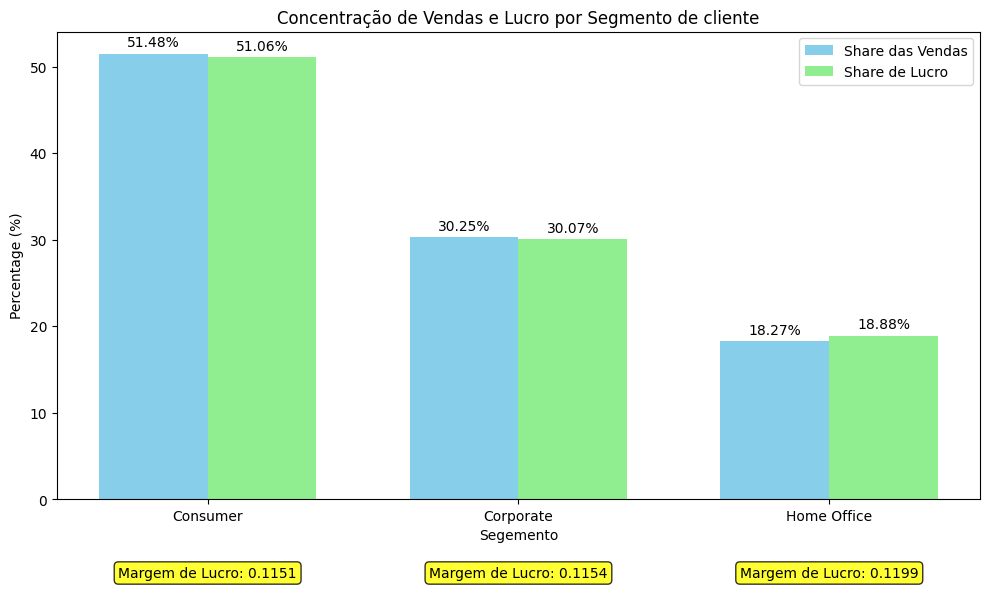

In [0]:
pdf = _sqldf.toPandas()

segments = pdf['segment']
sales_percentage = pdf['sales_percentage'].astype(float)
profit_percentage = pdf['profit_percentage'].astype(float)
profit_margin = pdf['profit_margin'].astype(float)

bar_width = 0.35
x = np.arange(len(segments))

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(
    x - bar_width / 2,
    sales_percentage,
    bar_width,
    label='Share das Vendas',
    color='skyblue'
)
bars2 = ax.bar(
    x + bar_width / 2,
    profit_percentage,
    bar_width,
    label='Share de Lucro',
    color='lightgreen'
)

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(
        f'{height:.2f}%',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center',
        va='bottom',
        fontsize=10
    )

y_box = -max(sales_percentage.max(), profit_percentage.max()) * 0.15
for i, m in enumerate(profit_margin):
    ax.text(
        x[i],
        y_box,
        f'Margem de Lucro: {m:.4f}',
        ha='center',
        va='top',
        fontsize=10,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', edgecolor='black', alpha=0.8)
    )

ax.set_xlabel('Segemento')
ax.set_ylabel('Percentage (%)')
ax.set_xticks(x)
ax.set_xticklabels(segments)
ax.legend(loc='upper right')

plt.title('Concentração de Vendas e Lucro por Segmento de cliente')
plt.tight_layout()
plt.show()

**2 - Qual segmeto faz o maior volume de compras ou que geraram o maior valor de vendas/lucro?**
A partir do resultado encontrado, vemos que o segmento Consumer é responsável pela maior parte dos volume de receita e também lucro, seguido de Corporate e Home office, respectivamente. 
Um ponto interessante é que a concentração de vendas e lucro é muito semelhante em cada segmento, fato confirmado por uma margem de luvro muito próxima, na casa dos ~12%, indicando que ainda que os segmentos sejam diferentes em volume, são quase igualmente "lucrativos", com o segmento Home office tendo um elev destaque, com o valor marginalmente superior de ~11,99%
 

![Screenshot 2025-12-05 at 14.30.53.png](./Screenshot 2025-12-05 at 14.30.53.png "Screenshot 2025-12-05 at 14.30.53.png")
Registro do gráfico gerado

#### 3 - Existe oportunidade de melhoria do resultado de lucro no portfolio de produtos?

In [0]:
%sql
WITH total AS (
  SELECT sum(item_sale) AS sales
  FROM workspace.default.fact_order_items
),
totalp AS (
  SELECT sum(item_profit) AS profit
  FROM workspace.default.fact_order_items
)
SELECT
  t1.product_id
  , t1.product_name
  , t1.category,
  sum(t2.item_sale) AS sales,
  ROUND((sum(t2.item_sale) / (SELECT sales FROM total))*100, 2) AS sales_percentage,
  ROUND(sum(t2.item_profit), 2) AS profit,
  ROUND((sum(t2.item_profit) / (SELECT profit FROM totalp))*100, 2) AS profit_percentage
FROM workspace.default.dim_products AS t1
LEFT JOIN workspace.default.fact_order_items AS t2
  ON t1.product_id = t2.product_id
GROUP BY 1,2,3
ORDER BY 6 DESC

product_id product_name category sales sales_percentage profit profit_percentage TEC-CO-10004722 Canon imageCLASS 2200 Advanced Copier Technology 61600.00 0.49 25199.94 1.72 OFF-AP-10004512 Hoover Stove, Red Office Supplies 21148.00 0.17 10345.58 0.71 TEC-PH-10004823 Nokia Smart Phone, Full Size Technology 22261.00 0.18 8121.47 0.55 OFF-BI-10003527 Fellowes PB500 Electric Punch Plastic Comb Binding Machine with Manual Bind Office Supplies 27454.00 0.22 7753.06 0.53 TEC-CO-10001449 Hewlett Packard LaserJet 3310 Copier Technology 18840.00 0.15 6983.89 0.48 FUR-CH-10002250 Office Star Executive Leather Armchair, Black Furniture 15289.00 0.12 6123.26 0.42 TEC-PH-10004664 Nokia Smart Phone, with Caller ID Technology 30042.00 0.24 5455.96 0.37 OFF-AP-10002330 Hamilton Beach Stove, Silver Office Supplies 18248.00 0.14 5452.46 0.37 TEC-PH-10000303 Samsung Smart Phone, VoIP Technology 16797.00 0.13 5356.81 0.37 FUR-CH-10002203 SAFCO Executive Leather Armchair, Black Furniture 12301.00 0.10 5003.1 0.34 TEC-PH-10000169 ARKON Windshield Dashboard Air Vent Car Mount Holder Technology 13553.00 0.11 4938.57 0.34 TEC-PH-10000169 Apple Smart Phone, with Caller ID Technology 13553.00 0.11 4938.57 0.34 FUR-BO-10004852 Sauder Classic Bookcase, Traditional Furniture 14475.00 0.11 4861.07 0.33 TEC-CO-10004997 Hewlett Wireless Fax, Color Technology 10610.00 0.08 4854.27 0.33 FUR-BO-10004999 Safco Classic Bookcase, Metal Furniture 10372.00 0.08 4681.86 0.32 FUR-BO-10001471 Sauder Classic Bookcase, Metal Furniture 10538.00 0.08 4650.45 0.32 TEC-CAN-10001437 Canon Wireless Fax, Laser Technology 9618.00 0.08 4596.32 0.31 TEC-CO-10003763 Canon PC1060 Personal Laser Copier Technology 11620.00 0.09 4570.94 0.31 TEC-PH-10003457 Cisco Smart Phone, Full Size Technology 14271.00 0.11 4507.81 0.31 TEC-AC-10002049 Logitech G19 Programmable Gaming Keyboard Technology 13758.00 0.11 4425.32 0.3 TEC-AC-10002049 Plantronics Savi W720 Multi-Device Wireless Headset System Technology 13758.00 0.11 4425.32 0.3 TEC-PH-10001751 Samsung Smart Phone, Cordless Technology 14563.00 0.12 4338.81 0.3 TEC-PH-10001670 Motorola Smart Phone, Full Size Technology 13821.00 0.11 4237.33 0.29 TEC-PH-10002623 Cisco Smart Phone, with Caller ID Technology 13215.00 0.10 4055.9 0.28 FUR-BO-10001501 Bush Classic Bookcase, Metal Furniture 11561.00 0.09 4042.76 0.28 TEC-PH-10000780 Cisco Smart Phone, with Caller ID Technology 11657.00 0.09 3938.36 0.27 FUR-BO-10002990 Dania Library with Doors, Traditional Furniture 9198.00 0.07 3913.27 0.27 TEC-AC-10001056 Belkin Router, USB Technology 8288.00 0.07 3894.72 0.27 TEC-MA-10003979 Ativa V4110MDD Micro-Cut Shredder Technology 7700.00 0.06 3772.95 0.26 TEC-MA-10001047 3D Systems Cube Printer, 2nd Generation, Magenta Technology 14300.00 0.11 3717.97 0.25 TEC-MA-10001127 Epson Inkjet, Wireless Technology 19146.00 0.15 3647.83 0.25 TEC-MA-10001127 "HP Designjet T520 Inkjet Large Format Printer - 24"" Color" Technology 19146.00 0.15 3647.83 0.25 TEC-PH-10000030 Samsung Smart Phone, with Caller ID Technology 13716.00 0.11 3638.28 0.25 OFF-ST-10002555 Eldon Lockers, Industrial Office Supplies 8969.00 0.07 3604.14 0.25 TEC-APP-10002966 Apple Smart Phone, Full Size Technology 12751.00 0.10 3570.0 0.24 TEC-CO-10000013 Brother Fax Machine, Laser Technology 10879.00 0.09 3548.09 0.24 FUR-SAU-10004653 Sauder Classic Bookcase, Traditional Furniture 8894.00 0.07 3491.95 0.24 TEC-CO-10004567 Brother Fax Machine, Color Technology 7856.00 0.06 3455.26 0.24 OFF-AP-10001931 Hoover Blender, Black Office Supplies 9679.00 0.08 3436.43 0.23 OFF-AP-10001931 Cuisinart Stove, Red Office Supplies 9679.00 0.08 3436.43 0.23 TEC-CO-10001654 Hewlett Wireless Fax, Digital Technology 9482.00 0.07 3429.86 0.23 FUR-BO-10002300 Safco 3-Shelf Cabinet, Mobile Furniture 9070.00 0.07 3428.74 0.23 FUR-BO-10002300 Dania Classic Bookcase, Traditional Furniture 9070.00 0.07 3428.74 0.23 FUR-CH-10000932 Harbour Creations Executive Leather Armchair, Red Furniture 8185.00 0.06 3387.83 0.23 TEC-PH-

In [0]:
pdf = _sqldf.toPandas()

fig = px.scatter(
    pdf,
    x='sales',
    y='profit',
    color='category',
    hover_name='product_name',
    labels={'sales': 'Vendas', 'profit': 'Lucro', 'category': 'Categoria'},
    title='Venda e Lucro por Produto e categoria',
    size_max=80
)

mean_sales = pdf['sales'].mean()
mean_profit = pdf['profit'].mean()

fig.add_vline(
    x=mean_sales,
    line_dash="dash",
    line_color="grey",
    line_width=1,
    annotation_text="Média de vendas",
    annotation_position="top right"
)
fig.add_hline(
    y=mean_profit,
    line_dash="dash",
    line_color="grey",
    line_width=1,
    annotation_text="Média de lucro",
    annotation_position="top right"
)

fig.add_vline(x=0, line_color="grey", line_width=1)
fig.add_hline(y=0, line_color="grey", line_width=1)

fig.update_layout(
    legend_title_text='Categoria',
    legend=dict(x=0.99, y=0.01, xanchor='right', yanchor='bottom'),
    width=900,
    height=600,
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.show()

**3 - Existe oportunidade de melhoria do resultado de lucro no portfolio de produtos?**

A partir do gráfico interativo constrído, conseguimos ter uma visão interessante sobre o estado de vendas e lucro. Em resumo, todos os items na área negativa do eixo Y correpondem a items vendidos, porém com margem de lucro negativa. Items como a Cubify X 3D Printer e Bevis conference Table apresentam um volume de vendas superior a 10k, porém com um prejuízo alto acumulado. 

Com o uso do gráfico interativo é possível montar frentes de investigação que analisem em detalhes os produtos de margem negativa e identifiquem planos de ação para a correção de rota. 

Registro do gráfico gerado
![Screenshot 2025-12-05 at 14.31.41.png](./Screenshot 2025-12-05 at 14.31.41.png "Screenshot 2025-12-05 at 14.31.41.png")
Recortes interativos, executados para explorar os resultados
![Screenshot 2025-12-04 at 09.35.23.png](./Screenshot 2025-12-04 at 09.35.23.png "Screenshot 2025-12-04 at 09.35.23.png")![Screenshot 2025-12-04 at 09.35.31.png](./Screenshot 2025-12-04 at 09.35.31.png "Screenshot 2025-12-04 at 09.35.31.png")

#### 4 - Qual é o desempenho de vendas e lucro por mercado?

In [0]:
%%sql
WITH total AS (
  SELECT sum(order_sale) AS sales
  FROM workspace.default.fact_orders
),
totalp AS (
  SELECT sum(order_profit) AS profit
  FROM workspace.default.fact_orders
)
SELECT
  t1.market,
  sum(t2.order_sale) AS sales,
  ROUND((sum(t2.order_sale) / (SELECT sales FROM total))*100, 1) AS sales_percentage,
  ROUND(sum(t2.order_profit), 2) AS profit,
  ROUND((sum(t2.order_profit) / (SELECT profit FROM totalp))*100, 1) AS profit_percentage
FROM workspace.default.dim_stores AS t1
LEFT JOIN workspace.default.fact_orders AS t2
  ON t1.store_code = t2.store_code
GROUP BY 1
ORDER BY 2 DESC

market sales sales_percentage profit profit_percentage APAC 3592582.00 28.4 437523.79 29.8 EU 2856971.00 22.6 351387.19 23.9 US 2297354.00 18.2 286397.29 19.5 LATAM 2164687.00 17.1 221643.66 15.1 EMEA 880603.00 7.0 63816.89 4.3 Africa 783776.00 6.2 88871.51 6.1 Canada 66932.00 0.5 17817.39 1.2

DataFrame[market: string, sales: decimal(28,2), sales_percentage: decimal(34,1), profit: double, profit_percentage: double]

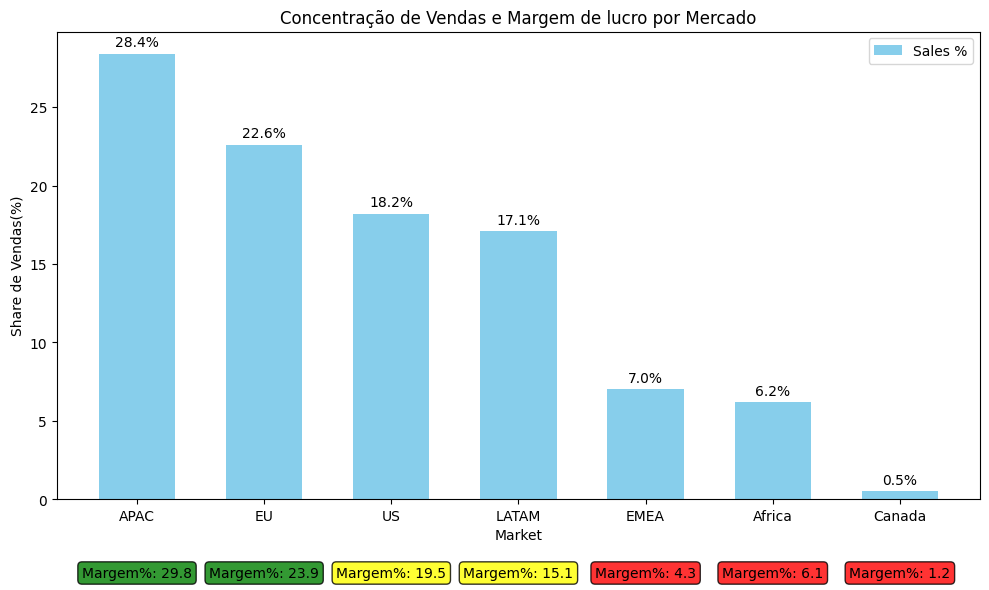

In [0]:
pdf = _sqldf.toPandas()

markets = pdf['market']
sales_percentage = pdf['sales_percentage'].astype(float)
profit_percentage = pdf['profit_percentage'].astype(float)

bar_width = 0.6
x = np.arange(len(markets))

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    x,
    sales_percentage,
    bar_width,
    color='skyblue',
    label='Sales %'
)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.annotate(
        f'{height:.1f}%',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center',
        va='bottom',
        fontsize=10
    )

def get_color(pct):
    if pct >= profit_percentage.max() * 0.8:
        return 'green'
    elif pct >= profit_percentage.max() * 0.5:
        return 'yellow'
    else:
        return 'red'

y_box = -max(sales_percentage) * 0.15
for i, pct in enumerate(profit_percentage):
    ax.text(
        x[i],
        y_box,
        f'Margem%: {pct:.1f}',
        ha='center',
        va='top',
        fontsize=10,
        bbox=dict(boxstyle='round,pad=0.3', facecolor=get_color(pct), edgecolor='black', alpha=0.8)
    )

ax.set_xlabel('Market')
ax.set_ylabel('Share de Vendas(%)')
ax.set_xticks(x)
ax.set_xticklabels(markets)
ax.legend(loc='upper right')

plt.title('Concentração de Vendas e Margem de lucro por Mercado')
plt.tight_layout()
plt.show()

**4 - Qual é o desempenho de vendas e lucro por mercado?** 

Analisando a distribuição de vendas e e as respectivas margem de lucro por região enxergamos um cenário interessante e positivo: com cerca de 50% das vendas concentradas em mercados onde a margem de lucro é mais alta. Como ação imediata, recomendamos focar as investigações em relação  a possíveis caminhos de melhoria de margem em mercados como US e LATAM, visto que pelo o volume de vendas concentrado nessas áreas, o impacto na melhoria de 1% de margem seria alto. 

![Screenshot 2025-12-05 at 14.33.08.png](./Screenshot 2025-12-05 at 14.33.08.png "Screenshot 2025-12-05 at 14.33.08.png")
Registro do gráfico construído


#### 5 - Quais as combinações de produto/mercado que têm gerado a maior margem de lucro?

In [0]:
%%sql

WITH total AS (
  SELECT sum(item_sale) AS sales
  FROM workspace.default.fact_order_items
),
totalp AS (
  SELECT sum(item_profit) AS profit
  FROM workspace.default.fact_order_items
)
SELECT
 t4.market
  , t1.product_id
  , t1.product_name
  ,sum(t2.item_sale) AS sales,
  ROUND((sum(t2.item_sale) / (SELECT sales FROM total))*100, 2) AS sales_percentage,
  ROUND(sum(t2.item_profit), 2) AS profit,
  ROUND((sum(t2.item_profit) / (SELECT profit FROM totalp))*100, 2) AS profit_percentage
FROM workspace.default.dim_products AS t1
LEFT JOIN workspace.default.fact_order_items AS t2
  ON t1.product_id = t2.product_id
LEFT JOIN workspace.default.fact_orders AS t3
  ON t2.order_id = t3.order_id
LEFT JOIN workspace.default.dim_stores AS t4
  ON t3.store_code = t4.store_code
GROUP BY 1,2,3
ORDER BY 4 DESC

market product_id product_name sales sales_percentage profit profit_percentage US TEC-CO-10004722 Canon imageCLASS 2200 Advanced Copier 61600.00 0.49 25199.94 1.72 EU OFF-AP-10004512 Hoover Stove, Red 30131.00 0.24 14779.4 1.01 APAC TEC-PH-10004664 Nokia Smart Phone, with Caller ID 30042.00 0.24 5455.96 0.37 US OFF-BI-10003527 Fellowes PB500 Electric Punch Plastic Comb Binding Machine with Manual Bind 27454.00 0.22 7753.06 0.53 EU TEC-PH-10004823 Nokia Smart Phone, Full Size 23533.00 0.19 8668.43 0.59 US TEC-MA-10002412 Cisco TelePresence System EX90 Videoconferencing Unit 22638.00 0.18 -1811.08 -0.12 US FUR-CH-10002024 HON 5400 Series Task Chairs for Big and Tall 21870.00 0.17 0.0 0.0 APAC FUR-CH-10000027 SAFCO Executive Leather Armchair, Black 21329.00 0.17 1363.23 0.09 US OFF-BI-10001359 GBC DocuBind TL300 Electric Binding System 19824.00 0.16 2233.5 0.15 EU OFF-AP-10002330 Hamilton Beach Stove, Silver 19606.00 0.16 5126.58 0.35 US OFF-BI-10000545 GBC Ibimaster 500 Manual ProClick Binding System 19026.00 0.15 760.98 0.05 US TEC-CO-10001449 Hewlett Packard LaserJet 3310 Copier 18840.00 0.15 6983.89 0.48 APAC TEC-PH-10001457 Apple Smart Phone, Full Size 18718.00 0.15 1695.3 0.12 EU TEC-PH-10000160 Motorola Signal Booster, Cordless 18625.00 0.15 2220.53 0.15 EU TEC-PH-10000160 Motorola Smart Phone, with Caller ID 18625.00 0.15 2220.53 0.15 US TEC-MA-10001127 Epson Inkjet, Wireless 18375.00 0.15 4094.98 0.28 US TEC-MA-10001127 "HP Designjet T520 Inkjet Large Format Printer - 24"" Color" 18375.00 0.15 4094.98 0.28 US OFF-BI-10004995 GBC DocuBind P400 Electric Binding System 17965.00 0.14 -1878.17 -0.13 APAC FUR-BO-10004679 Safco Library with Doors, Pine 17433.00 0.14 375.23 0.03 APAC FUR-CH-10002247 Hon Executive Leather Armchair, Adjustable 17122.00 0.14 1855.7 0.13 APAC FUR-BO-10001934 Bush Library with Doors, Metal 17093.00 0.14 -309.34 -0.02 US OFF-SU-10000151 High Speed Automatic Electric Letter Opener 17031.00 0.13 -262.0 -0.02 US TEC-MA-10000822 Lexmark MX611dhe Monochrome Laser Printer 16830.00 0.13 -4589.97 -0.31 APAC TEC-PH-10000303 Samsung Smart Phone, VoIP 16797.00 0.13 5356.81 0.37 APAC FUR-CH-10002213 Hon Executive Leather Armchair, Black 16702.00 0.13 -1811.36 -0.12 US OFF-SU-10002881 Martin Yale Chadless Opener Electric Letter Opener 16656.00 0.13 -1299.19 -0.09 EU OFF-ST-10002506 Smead Lockers, Blue 16310.00 0.13 169.5 0.01 LATAM TEC-PH-10004196 Samsung Smart Phone, Cordless 16274.00 0.13 -1951.08 -0.13 EU FUR-BO-10003103 Dania Floating Shelf Set, Pine 16118.00 0.13 464.22 0.03 EU FUR-BO-10003103 Ikea Classic Bookcase, Metal 16118.00 0.13 464.22 0.03 US OFF-BI-10001120 Ibico EPK-21 Electric Binding System 15876.00 0.13 3345.29 0.23 EU TEC-PH-10002035 Samsung Smart Phone, Cordless 15815.00 0.13 -824.31 -0.06 EU OFF-AP-10001623 Hoover Stove, White 15753.00 0.12 -6856.42 -0.47 US FUR-BO-10004834 Riverside Palais Royal Lawyers Bookcase, Royale Cherry Finish 15611.00 0.12 -669.53 -0.05 US FUR-BO-10004834 Safco 3-Shelf Cabinet, Mobile 15611.00 0.12 -669.53 -0.05 APAC FUR-CH-10000602 Novimex Executive Leather Armchair, Red 15560.00 0.12 -345.8 -0.02 APAC FUR-CH-10003950 Novimex Executive Leather Armchair, Black 15455.00 0.12 -981.09 -0.07 APAC FUR-CH-10002250 Office Star Executive Leather Armchair, Black 15289.00 0.12 6123.26 0.42 LATAM TEC-PH-10002815 Samsung Smart Phone, VoIP 15101.00 0.12 1077.34 0.07 EU OFF-ST-10001758 Rogers Lockers, Blue 14919.00 0.12 -827.2 -0.06 EU TEC-PH-10000493 Apple Smart Phone, Full Size 14887.00 0.12 2492.63 0.17 EU TEC-PH-10002759 Cisco Smart Phone, Cordless 14723.00 0.12 3387.35 0.23 APAC TEC-PH-10001751 Samsung Smart Phone, Cordless 14563.00 0.12 4338.81 0.3 APAC FUR-BO-10004852 Sauder Classic Bookcase, Traditional 14475.00 0.11 4861.07 0.33 APAC FUR-CH-10002573 Office Star Executive Leather Armchair, Adjustable 14416.00 0.11 1292.7 0.09 US TEC-MA-10001047 3D Systems Cube Printer, 2nd Generation, Magenta 14300.00 0.11 3717.97 0.25 LATAM TEC-PH-10003457 Cisco Smart Phone, Full Size 1427

DataFrame[market: string, product_id: string, product_name: string, sales: decimal(28,2), sales_percentage: decimal(35,2), profit: double, profit_percentage: double]

In [0]:
pdf = _sqldf.toPandas()

fig = px.scatter(
    pdf,
    x='sales',
    y='profit',
    color='market',
    hover_name='product_name',
    labels={'sales': 'Vendas', 'profit': 'Lucro', 'market': 'Mercado'},
    title='Venda e Lucro por Produto e Mercado',
    size_max=80
)

median_sales = pdf['sales'].mean()
median_profit = pdf['profit'].mean()

fig.add_vline(
    x=median_sales,
    line_dash="dash",
    line_color="black",
    line_width=1.5,
    annotation_text="Média de vendas",
    annotation_position="top right"
)
fig.add_hline(
    y=median_profit,
    line_dash="dash",
    line_color="gray",
    line_width=1.5,
    annotation_text="Média de lucro",
    annotation_position="top right"
)

fig.add_vline(x=0, line_color="grey", line_width=1)
fig.add_hline(y=0, line_color="grey", line_width=1)

fig.update_layout(
    legend_title_text='Mercado',
    legend=dict(
        orientation="h",
        x=0.5,
        y=1.08,
        xanchor='center',
        yanchor='top'
    ),
    width=900,
    height=600,
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.show()

**5 - Quais as combinações de produto/mercado que têm gerado a maior margem de lucro?** 

De maneira análoga ao gráfico de dispersão da análise 3, o gráfico interativo acima permite a identificação das combinações de produto/mercado com pior performance de lucro, a partit da seleção dos produtos abaixo da linha 0 do eixo y. 
No caso, os produtos Cubefy Cube X 3D printer no US, Motorola Smartphone, Cordless na EMEA e o Hover Stove no EU apresentaram grande resultados de venda, mas com um prejuízo acumulado. É importante investigar os produtos em questão e traçar planos de ação para corrigir a performance. 

Registro do gráfico gerado
![Screenshot 2025-12-05 at 14.34.27.png](./Screenshot 2025-12-05 at 14.34.27.png "Screenshot 2025-12-05 at 14.34.27.png")

Recortes interativos realizados para gerar as conclusões. 
![Screenshot 2025-12-04 at 14.35.20.png](./Screenshot 2025-12-04 at 14.35.20.png "Screenshot 2025-12-04 at 14.35.20.png")![Screenshot 2025-12-04 at 14.35.28.png](./Screenshot 2025-12-04 at 14.35.28.png "Screenshot 2025-12-04 at 14.35.28.png")![Screenshot 2025-12-04 at 14.36.26.png](./Screenshot 2025-12-04 at 14.36.26.png "Screenshot 2025-12-04 at 14.36.26.png")

#PARTE 5 - Fechamento e Auto avaliação



#### Conclusões gerais 
Com a solução desenhada, foi possível aplicar os principais conceitos e habilidades adquitidos na discplina, executando na prática a constrção de um Data Warehouse e utilização como fonte de dados para a execução de análises e extração do resultado. 

#### Auto-avaliação 

- Visão geral da solução
  - Em geral, acredito que a solução construída tem bases sólidas na teoria aplicada, e oferece soluções com performance adequada para o desafio proposto. 
  - Em um cenário real, a infraestrutura de tabelas construídas seria satisfatória para a geração da lista das análises relacionadas as perguntas listadas, e forneceria uma boa fonte de informação para a excução dessas e outras análises no dia a dia do negócio.

- Diferenças entre cenário construído e realidade
  - NO entanto, é importante destacar alguns gaps no projeto construído. Em linhas gerais, a maior diferença do cenáio trabalhado para um setup de dia a dia vem da falta de normalização e da descentralização das fontes de dados no dia a dia de um negócio. 
  - No cenário trabalhado, todas as informações usada vinham de uma única tabela já normalizada e tratada, que foi quebrada através de múltiplos processos de ETL, de forma a resultar em um modelo estrela otimizado para os processos analíticos. 
  - Ainda que esse cenário tenha permitido a prática do proceso de ETL, ele não traz o legado que normalmente encontramos ao encarar esses desafio: dados vindos de múltiplos sistemas diferentes, em formatos diferentes, tipos de arquivo diferentes, granularidades diferentes entre outros elementos que tornam o processo de construção, alimentação e manutenção de um DW desafiadores. 

- Oportunidades de aprofundamento e melhoria
  - Além disso, para fins de simplificação de escopo, algumas decisões foram tomadas e premissas assumidas. por exemplo, a opção do resumo das vendas de Store no nível de País. Ao passo que isso reduziu a complexidade dos dados e ainda permitiu o trabalho, no dia a dia a realidade iria exigir o trabalho dos dados em sua completa granularidade, explorando dods os dados num nível cidade, e exigindo também dados sobre as unidades de venda, centros de abastecimentos, e outros elementos que, na base de dados atual, não estão disponíveis. 

  - Além disso, do ponto de vista de tempo, ainda seria possível introduzir mais detalhes como dia da semana, número do dia no ano, entre outros. 

- Uso de recursos interativos e de visualização
  - Como elemento positivo, vale reforçar o uso do os gráficos interativos como ferramenta exploratória para a resolução das perguntas, a partir dos daods analisados. 

  - Essa ecolha foi realizada não só pela facilidade e personalização introduzidas, mas também porque replicam um uso cada vez mais comum das infraestrutura construída: a conexão de dados de um DW como fonte de entrada em ferramentas de self service BI (como Tableau, Power BI, Looker Studio) para permitir que usuários finais, não familiares com o código e a engenharia necessária para a conexão com os sistemas raiz, façam uso de dados de qualidade, tratados e validados, permitindo que toda a organização se baseie nos dados disponíveis para exploração e tomada de decisão. 